Binary classifier to perform sentiment analysis on an IMDB dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re

import string
import tensorflow as tf
import numpy as np

from keras import layers
from keras import losses

Download and explore the IMDB dataset

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", 
                                  url ,
                                  untar = True,
                                  cache_dir='.',
                                  cache_subdir=''
                                  )

dataset_dir = os.path.join(os.path.dirname(dataset),'stack_overflow_16k')

In [3]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review.

In [5]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

Load Dataset

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Query", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Query b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default construc

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


Preprocessing - 
Standardize, tokenize and vectorize
Standardization refers to removal of punctuation or HTML elements.
Tokenization is splitting strings into tokens(smallest unit(root word)).
Vectorization is converting tokens into numbers so they can be fed into a neural network.
All of these tasks can be done using tf.keras.layers.TextVectorization layer.

In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Query", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Query", vectorize_text(first_review, first_label))

Query tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra

In [16]:
#To see which integer corresponds to by calling .get_vocabulary()
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Two important methods you should use when loading data to make sure that I/O does not become blocking.
.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
.prefetch() overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model Creation

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [21]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              
              metrics=['accuracy'])

In [22]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50

200/200 [==============================] - 6s 22ms/step - loss: 1.3782 - accuracy: 0.3352 - val_loss: 1.3652 - val_accuracy: 0.4794
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 1.3478 - accuracy: 0.4627 - val_loss: 1.3249 - val_accuracy: 0.5319
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 1.2966 - accuracy: 0.5359 - val_loss: 1.2643 - val_accuracy: 0.5875
Epoch 4/50
200/200 [==============================] - 2s 8ms/step - loss: 1.2272 - accuracy: 0.5852 - val_loss: 1.1917 - val_accuracy: 0.6388
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 1.1503 - accuracy: 0.6223 - val_loss: 1.1182 - val_accuracy: 0.6600
Epoch 6/50
200/200 [==============================] - 1s 7ms/step - loss: 1.0765 - accuracy: 0.6644 - val_loss: 1.0498 - val_accuracy: 0.6988
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: 1.0107 - accuracy: 0.6970 - val_loss: 0.9875 - val_accuracy: 0.7200
Epoc

In [23]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 13ms/step - loss: 0.5304 - accuracy: 0.8012
Loss:  0.5304229855537415
Accuracy:  0.8012499809265137


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

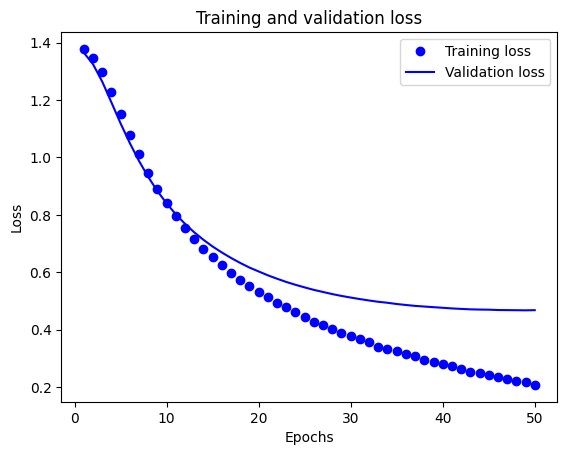

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

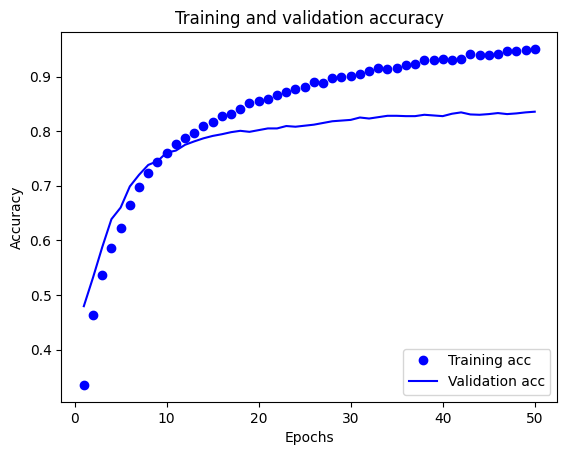

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [27]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer="adam", 
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 5s 19ms/step - loss: 0.5304 - accuracy: 0.8012
0.8012499809265137


In [51]:
examples = [
  "what is the use of console.log()?",
  "How to declare function in csharp csharp csharp?",
  "why do i get module not found error even though the package is installed using pip?"
]

pred = export_model.predict(examples)

1/1 [==============================] - 0s 101ms/step


In [53]:
pred_lab = []
ind = []

for i in range(0,len(pred)):
    ind.append(np.argmax(pred[i]))

for i in range(0,len(ind)):
    pred_lab.append(raw_train_ds.class_names[ind[i]]) 

pred_lab

['javascript', 'csharp', 'python']